In [1]:
from src import kernel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1

/root/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/root/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
df = pd.read_csv('./src/kernel/data/test_data1.csv')

In [3]:
df.head()

,0,1
0,-3.620286,-2.358816
1,-0.132184,-3.247832
2,-2.912721,-1.521750
3,-5.144268,4.760700
4,-5.693922,-2.663462


In [4]:
kM = kernel.Mean(df,sigma='silverman')

In [5]:
x = np.arange(-10.0,10,0.1)
y = np.arange(-10.0,10,0.1)
xx,yy = np.meshgrid(x,y)
z = kM.mu_p(np.array([xx.ravel(),yy.ravel()]).T)
zz = z.reshape(xx.shape[0],-1)

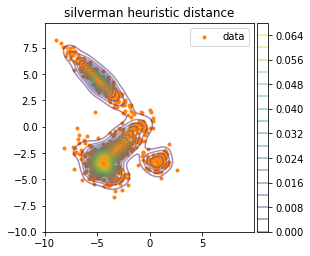

In [6]:
fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)
bar = ax.contour(xx,yy,zz,20,alpha=0.5)
ax.scatter(df.iloc[:,0],df.iloc[:,1],alpha=1,marker='.',color='C1',label='data')
ax.set_title('silverman heuristic distance')

ax.legend()
ax.axis("image")
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cax = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cax)
fig.colorbar(bar,cax=cax)
fig.show()

In [321]:
from src.kernel import Mean as kernelMean
from src.kernel.utils.progressbar import progbar
from src.kernel.utils.functions import gauss_kernel,get_band_width

import scipy as scp

class KernelHerding():
    def __init__(self, obj_KernelMean):
        if not isinstance(obj_KernelMean, kernelMean):
             raise TypeError(f"init object shuld be KernelMean class, but got {type(obj_KernelMean)}")

        self.KM = obj_KernelMean
        self.kernel = gauss_kernel(self.KM.sigma)
        
    def supersample(self, 
                    sample_size, 
                    verbose={'clear_display':True, 'display':'notebook'},
                    optimizer='scipy_optim',
                    **args):
        '''
        sample_size: sample size of herding.
        verbose:
            clear_display: {True | False}
                Overwrite progress bar when updating herding progress bar.
            display: {'notebook' | 'command'}
                Execution environment is ipython notebook or command line.
        optimizer: {'scipy_optim'|'optuna'}
        args:
            see scipy.optimizer.minimize args
        '''
        
        
        prob = progbar(sample_size, **verbose)
        h = self.KM.mu_p
        x1 = self._argmax(h, optimizer, **args)
        samples = np.array([x1])
        for idx in range(sample_size-1):
            h = self._herding_update(samples)
            x = self._argmax(h, optimizer, **args)
            samples = np.append(samples,np.array([x]),axis=0)
            prob.update(idx+1)
            
            self.samples = samples
            
        del prob
        return samples
    
    def _argmax(self, h, optimizer, **args):
        minus_h = lambda x: -1.*h(x)
        if optimizer=='scipy_optim':
            optimize_result = self._optimizer_scipy(minus_h,**args)
            return optimize_result.x
        
    def _herding_update(self, samples):
        f = lambda x: self.KM.mu_p(x) - np.average(self.kernel(x,samples),axis=1)
        return f
    
    def approximation_mean(self,x):
        #         , sigma='median'):
        #         if isinstance(sigma,str):
        #             sigma = get_band_width(self.samples, sigma)
        #         kernel = gauss_kernel(sigma)
        return np.average(self.kernel(x,self.samples),axis=1)
    
    def _kernel_gradient_from_samples(self,x,samples):
        return np.average(self.kernel.grad(x,samples), axis=2)
    
    def _optimizer_scipy(self, h, **args):
        if 'x0' not in args:
            args['x0'] = np.zeros_like(KH.KM.x.loc[0])
        if 'method' not in args:
            args['method'] = 'Powell'
            
        if 'jac' in args:
            if args['jac'] == 'grad':            
                if hasattr(self,'samples'):
                    args['jac'] = lambda x: -1*(self._kernel_gradient_from_samples(x, self.KM.x.values) - self._kernel_gradient_from_samples(x,self.samples))
                else:
                    args['jac'] = lambda x: -1*(self._kernel_gradient_from_samples(x, self.KM.x.values))
            else:
                raise ValueError(f'jac is not defined. The gradient is needed when using [CG, BFGS, l-bfgs-b,tnc, slsqp]')
                     
        optimize_result = scp.optimize.minimize(h, **args)
        return optimize_result
    
    def _optimizer_TPE(self,)

In [322]:
KH = KernelHerding(kM)

In [323]:
KH.KM.x.describe()

,0,1
count,1000.000000,1000.000000
mean,-3.698802,-0.739859
std,1.986628,3.548944
min,-8.908265,-6.690193
25%,-4.995719,-3.464427
50%,-4.025972,-2.250199
75%,-2.716522,2.914778
max,2.593504,8.208197


In [324]:
cons = ({'type': 'ineq',
         'fun' : lambda x: -(x[0] - 2.593)},
        {'type': 'ineq',
         'fun' : lambda x:  (x[0] + 8.9)},
        {'type': 'ineq',
         'fun' : lambda x: -(x[1] - 8.2)},
        {'type': 'ineq',
         'fun' : lambda x:  (x[1] + 6.6)})

_ = KH.supersample(100,method='SLSQP',constraints = cons,jac='grad')

'    100% |################################| 0day  0:00:00 Total time: 0day  0:00:02'

In [325]:
x = np.arange(-10.0,10,0.1)
y = np.arange(-10.0,10,0.1)
xx,yy = np.meshgrid(x,y)
z_kernelh = KH.approximation_mean(np.array([xx.ravel(),yy.ravel()]).T)
z = KH.KM.mu_p(np.array([xx.ravel(),yy.ravel()]).T)
zz_kernlh = z_kernelh.reshape(xx.shape[0],-1)
zz = z.reshape(xx.shape[0],-1)

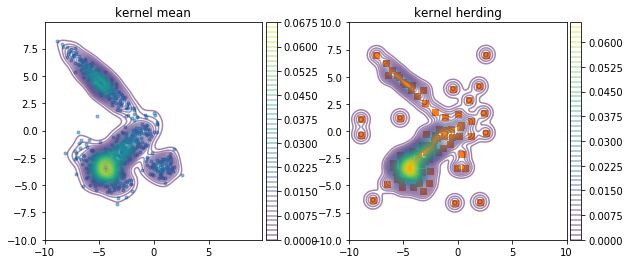

In [326]:
fig = plt.figure(figsize=[10,4])
ax1 = fig.add_subplot(121)
ax1.set_title('kernel mean')
cbar1 = ax1.contour(xx,yy,zz,50,alpha=0.5)
ax1.scatter(df.iloc[:,0],df.iloc[:,1],alpha=0.5,marker='.')
ax1.set_xlim([-10,10])
ax1.set_ylim([-10,10])
ax1.axis("image")
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax1)
cax = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cax)
fig.colorbar(cbar1,cax=cax)
fig.show()

ax2 = fig.add_subplot(122)
ax2.set_title('kernel herding')
cbar2 = ax2.contour(xx,yy,zz_kernlh,50,alpha=0.5)
ax2.scatter(KH.samples[:,0],KH.samples[:,1],marker='s',color='C1')
ax2.axis("image")
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax2)
cax2 = divider.new_horizontal(size="5%", pad=0.05)
ax2.set_xlim([-10,10])
ax2.set_ylim([-10,10])
fig.add_axes(cax2)
fig.colorbar(cbar2,cax=cax2)
fig.show()

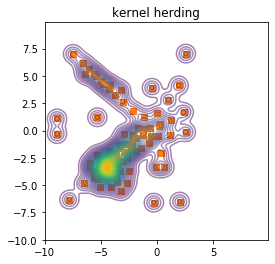

In [327]:
fig = plt.figure(figsize=[4,4])
ax2 = fig.add_subplot(111)
ax2.set_title('kernel herding')
cbar2 = ax2.contour(xx,yy,zz_kernlh,50,alpha=0.5)
ax2.scatter(KH.samples[:,0],KH.samples[:,1],marker='s',color='C1')
# ax2.axis("image")
# divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax2)
# cax2 = divider.new_horizontal(size="5%", pad=0.05)
# ax2.set_xlim([-10,10])
# ax2.set_ylim([-10,10])
# fig.add_axes(cax2)
# fig.colorbar(cbar2,cax=cax2)
fig.show()

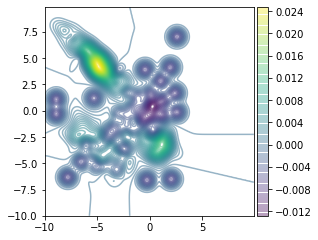

In [328]:
fig = plt.figure(figsize=[4,4])
ax1 = fig.add_subplot(111)
# ax1.scatter(KH.samples[:,0],KH.samples[:,1],color='r',marker='s')
cbar1 = ax1.contour(xx,yy,zz-zz_kernlh,100,alpha=0.5)
ax1.set_xlim([-10,10])
ax1.set_ylim([-10,10])
ax1.axis("image")
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax1)
cax = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cax)
fig.colorbar(cbar1,cax=cax)
fig.show()